**Jupyter Notebook illustrating first iteration of ISIMIP implementation integrated with default set of evaluation metrics**

In [13]:
# WHY???
import sys
sys.path.append("../")  # path contains python_file.py

In [103]:
from PACKAGE_NAME.evaluate import evaluation_functions
import iris
import numpy as np
import scipy
import matplotlib.pyplot as plt

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


**Variables to investigate**

In [99]:
variables = ['tas']

# Data import and pre-processing

In [91]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    obs = obs_all[:, :, 0:9000]
    obs_validate = obs_all[:, :, 9001:]
    cm_hist = cm[:, :, 0:9000]
    cm_future = cm[:, :, 9001:]

    dates = {
        "obs": get_dates(obs),
        "obs_validate": get_dates(obs_validate),
        "cm_hist": get_dates(cm_hist),
        "cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_future, dates


In [92]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_future, tas_dates = preprocess_isimip_evaluation_testing_data('tas')
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_future, pr_dates = preprocess_isimip_evaluation_testing_data('pr')

In [43]:
'''datasets = {
        "tas": {
        "obs_all": tas_obs_all,
        "hist_all": tas_hist_all,
        "obs": tas_obs_data,
        "hist": tas_hist_data
    },
    "pr": {
        "obs_all": pr_obs_all,
        "hist_all": pr_hist_all,
        "obs": pr_obs_data,
        "hist": pr_hist_data
    }
}'''

standard_variables_isimip = {
        "tas": {
        "lower_bound": -np.inf,
        "lower_threshold": -np.inf,
        "upper_bound": np.inf,
        "upper_threshold": np.inf,
        "distribution": scipy.stats.norm,
        "trend_preservation": "additive",
        "detrending": True,
        "name": '2m daily mean air temperature (K)',
        "high_threshold": 295,
        "low_threshold": 273
    },
    "pr": {
        "lower_bound": 0,
        "lower_threshold": 0.1 / 86400,
        "upper_bound": np.inf,
        "upper_threshold": np.inf,
        "distribution": scipy.stats.gamma,
        "trend_preservation": "mixed",
        "detrending": False,
        "name": 'Total precipitation (m/day)',
        "high_threshold": 0.0004,
        "low_threshold": 0.00001
    }
}

# Evaluation phase 1 - test assumptions

# Apply de-biasers

In [126]:
# from scipy.stats import norm, laplace - not sure I need this
from PACKAGE_NAME.debias import QuantileDeltaMapping, ISIMIP, QuantileMapping
from scipy.stats import norm, laplace
from PACKAGE_NAME.variables import Temperature, Precipitation

In [127]:
QDM_tas_debiaser = QuantileDeltaMapping(distribution=norm, time_window_length=50)
QM_tas_debiaser = QuantileMapping.from_variable(variable=Temperature, delta_type="additive")

In [128]:
tas_debiased_QDM = QDM_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_future)
tas_debiased_QM = QM_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_future)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/debias/_quantile_delta_mapping.py:128: RuntimeWarning: invalid value encountered in true_divide
  cm_future_time_window
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 49.71it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 784.31it/s]


In [96]:
QDM_pr_debiaser = QuantileDeltaMapping.from_variable(variable=Precipitation)

In [97]:
pr_debiased_QDM = QDM_pr_debiaser.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/utils/_math_utils.py:330: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98it/s]


In [98]:
pr_debiased_QDM

array([[[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       ...,

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]]])

# Evaluation of bias corrected results on validation period

## Marginal Aspects

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_2500/1250651362.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure2.show()
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_2500/1250651362.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure3.show()


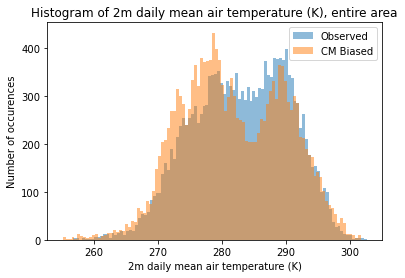

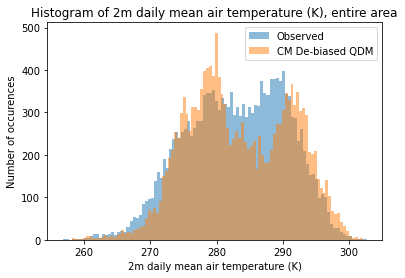

In [119]:
figure2 = evaluation_functions.histogram_plot('tas', 
                                    np.ndarray.flatten(tas_obs_validate), np.ndarray.flatten(tas_cm_future), 
                                   'Observed','CM Biased')
figure2.show()

figure3 = evaluation_functions.histogram_plot('tas', 
                                    np.ndarray.flatten(tas_obs_validate), np.ndarray.flatten(tas_debiased_QDM),
                                    'Observed','CM De-biased QDM')
figure3.show()
    
#evaluation_functions.marginal_bias_plot(tas_obs_validate, tas_cm_future, 'tas')

#evaluation_functions.marginal_bias_plot(tas_obs_validate, tas_debiased_QDM, 'tas')

In [123]:
np.ndarray.flatten(tas_debiased_QDM)

test = np.ndarray.flatten(tas_debiased_QDM[~np.isnan(tas_debiased_QDM)])

In [121]:
np.ndarray.flatten(tas_debiased_QDM).shape

(16592,)

In [131]:
tas_debiased_QM[~np.isnan(tas_debiased_QM)].shape

(16392,)